<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/sgd_minima_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Low vs high variance of loss across minibatches.

Code by Ferenc Huszar.
 Reproduces hand-drawn figure from 
 https://www.inference.vc/notes-on-the-origin-of-implicit-regularization-in-stochastic-gradient-descent/



In [2]:
import numpy as np

try:
    import GPy
except ModuleNotFoundError:
    %pip install -qq gpy
    import GPy
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
def huber(x, offset, delta):
    """Huber function. An analytic function that is quadratic around its minimum n
    and linear in its tails. Its minimum is at offset. Quadratic between
    offset-delta and offset + delta and linear outside."""
    i = np.abs(x - offset) < delta
    return (x - offset) ** 2 / 2 * i + (1 - i) * delta * (np.abs(x - offset) - delta / 2)

In [6]:
n_batches = 100
np.random.seed(0)

x = np.array([np.linspace(-10, 10, 100)] * n_batches).T

# Gaussian process draws to make the loss functions look more 'natural'
k = GPy.kern.RBF(input_dim=1, lengthscale=2.5)
mu = np.zeros_like(x[:, 0])
C = k.K(x[:, 0:1], x[:, 0:1])
gp_paths = np.random.multivariate_normal(mu, C, n_batches)

# construct minibatch losses as Huber functions at random locations + some GP
# paths to make them look less linear at their tails.
f = (
    huber(x, np.random.randn(1, n_batches) * 7, np.random.rand(1, n_batches) * 2 + 0.5)
    + np.random.rand(1, n_batches) * 5
    + 0.8 * gp_paths.T
)

# in the "low minibatch variance" scenario the loss functions are actually going
# to be a convex combination of the minibatch losses from the high-variance scenario
# and te average loss.
p = 0.23
g = p * f + (1 - p) * f.mean(1, keepdims=True)

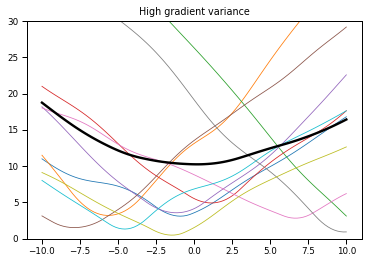

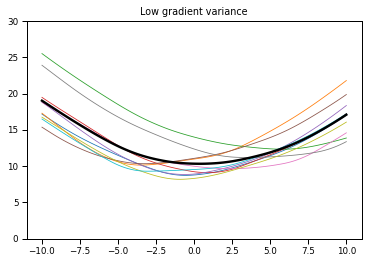

In [8]:
sns.set_context("paper")

fig, ax = plt.subplots()
ax.plot(x[:, :10], f[:, :10], linewidth=0.8)
ax.plot(x.mean(1), f[:, :10].mean(1), "k", linewidth=2.4)
ax.set_ylim([0, 30])
ax.set_title("High gradient variance")
plt.savefig("sgd_minima_unstable.pdf")

fig, ax = plt.subplots()
ax.plot(x[:, :10], g[:, :10], linewidth=0.8)
ax.plot(x.mean(1), g.mean(1), "k", linewidth=2.4)
ax.set_ylim([0, 30])
ax.set_title("Low gradient variance")
plt.savefig("sgd_minima_stable.pdf")

plt.show()